In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import re
from collections import Counter
import json
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
import re
from collections import Counter


def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r'(.)\1+', r'\1\1', text)
    text = re.sub(r'[.,:]', '', text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'@\w+', '[name]', text)
    return text

def tokenize_text(text):
    return clean_text(text).split()

nameslist = pd.read_csv('../../data/names.csv')
nameslist = nameslist['name'].tolist()

def build_vocab(texts):
    tokenized_texts = [tokenize_text(text) for text in texts]
    all_words = [word for text in tokenized_texts for word in text if word.isalnum()]
    word_counts = Counter(all_words)
    sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
    
    top_words = sorted_words[:1000]
    
    word_to_idx = {word: idx for idx, word in enumerate(top_words)}
    word_to_idx['<PAD>'] = len(word_to_idx)
    word_to_idx['[name]'] = len(word_to_idx)
    return word_to_idx, tokenized_texts


def is_illegal_word(word):
    return any(char.isalnum() == False for char in word) or word not in word_to_idx

def encode_sequences(tokenized_texts, word_to_idx):
    sequences = []
    for tokens in tokenized_texts:
        if len(tokens) < 2:  # Skip tweets that are too short
            continue
        for i in range(1, len(tokens)):
            if all(word in word_to_idx for word in tokens[:i+1]):
                encoded_seq = [word_to_idx[word] for word in tokens[:i]]
                encoded_target = word_to_idx[tokens[i]]
                sequences.append((encoded_seq, encoded_target))
    return sequences

# Load and preprocess data
folder_path = '../../data/x'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
csv_files = sorted(csv_files)[:20]

dfs = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)


df = pd.concat(dfs, ignore_index=True)
texts = df['text'].tolist()

print(f"Loaded {len(texts)} text samples from CSV.")

word_to_idx, tokenized_texts = build_vocab(texts)
sequences = encode_sequences(tokenized_texts, word_to_idx)

print(f"Vocabulary size: {len(word_to_idx)}")
print(f"Number of sequences: {len(sequences)}")

Loaded 198575 text samples from CSV.
Vocabulary size: 1002
Number of sequences: 489397


In [3]:
class TextDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, target = self.sequences[idx]
        return torch.tensor(sequence), torch.tensor(target)


def collate_fn(batch):
    sequences, targets = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=word_to_idx['<PAD>'])
    return sequences_padded, torch.tensor(targets)



class NextWordGRU(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout_prob=0.3):
        super(NextWordGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x):
        x = self.embedding(x)
        gru_out, _ = self.gru(x)
        gru_out = self.dropout(gru_out[:, -1, :])  # Take the last output
        out = self.fc(gru_out)
        return out


train_sequences, val_sequences = train_test_split(sequences, test_size=0.2, random_state=42)

train_dataset = TextDataset(train_sequences)
val_dataset = TextDataset(val_sequences)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, collate_fn=collate_fn)

model = NextWordGRU(vocab_size=len(word_to_idx), embed_size=128, hidden_size=256, num_layers=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


In [4]:

def validate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for sequences, targets in val_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == targets).sum().item()

    avg_loss = total_loss / len(val_loader)
    avg_acc = total_correct / len(val_loader.dataset)
    return avg_loss, avg_acc


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        total_loss = 0
        model.train()
        
        for batch_idx, (sequences, targets) in enumerate(train_loader):
            sequences, targets = sequences.to(device), targets.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()


        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_loss, val_acc = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)


     
        print(f'Epoch [{epoch+1}/{num_epochs}] completed, Average Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model = model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    model = best_model
    return train_losses, val_losses, val_accuracies


model = NextWordGRU(vocab_size=len(word_to_idx), embed_size=128, hidden_size=256, num_layers=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

print("Starting training...")
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Starting training...
Epoch [1/10] completed, Average Train Loss: 4.4138, Validation Loss: 4.0612, Validation Accuracy: 0.2191
Epoch [2/10] completed, Average Train Loss: 4.0303, Validation Loss: 3.9597, Validation Accuracy: 0.2331
Epoch [3/10] completed, Average Train Loss: 3.9114, Validation Loss: 3.9187, Validation Accuracy: 0.2369
Epoch [4/10] completed, Average Train Loss: 3.8303, Validation Loss: 3.9024, Validation Accuracy: 0.2388
Epoch [5/10] completed, Average Train Loss: 3.7658, Validation Loss: 3.8988, Validation Accuracy: 0.2390
Epoch [6/10] completed, Average Train Loss: 3.7083, Validation Loss: 3.9090, Validation Accuracy: 0.2378
Epoch [7/10] completed, Average Train Loss: 3.6582, Validation Loss: 3.9111, Validation Accuracy: 0.2416
Epoch [8/10] completed, Average Train Loss: 3.6140, Validation Loss: 3.9127, Validation Accuracy: 0.2411
Early stopping triggered


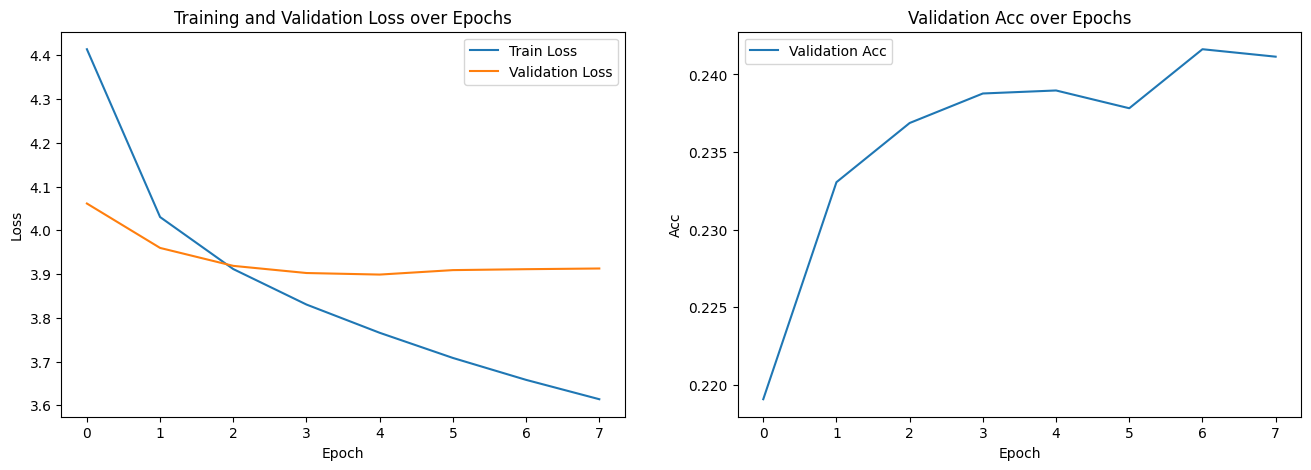

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(train_losses, label="Train Loss")
axs[0].plot(val_losses, label="Validation Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].legend()

axs[1].plot(val_accuracies, label="Validation Acc")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Acc")
axs[1].set_title("Validation Acc over Epochs")
axs[1].legend()

plt.show()

In [6]:
# Save the vocabulary and model
vocab_save_path = 'vocabulary_all_sequences_no_unk.json'
with open(vocab_save_path, 'w') as f:
    json.dump(word_to_idx, f)
print(f"Vocabulary saved to {vocab_save_path}")

model_save_path = 'model_all_sequences_no_unk.pth'
torch.save(model, model_save_path)
print(f"Model saved to {model_save_path}")


Vocabulary saved to vocabulary_all_sequences_no_unk.json
Model saved to model_all_sequences_no_unk.pth


In [7]:
def predict_next_word(model, sequence, idx_to_word):
    model.eval()
    sequence = torch.tensor(sequence).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(sequence)
        predicted_idx = torch.argmax(output, dim=1).item()
    return idx_to_word[predicted_idx]

idx_to_word = {idx: word for word, idx in word_to_idx.items()}

test_sequences = [
    "what did",
    "i love",
    "the weather is",
    "i cant wait to",
    "happy birthday to"
]

for seq in test_sequences:
    if all(word in word_to_idx for word in seq.split()):
        indata = [word_to_idx[word] for word in seq.split()]
        predicted_word = predict_next_word(model, indata, idx_to_word)
        print(f"Input: {seq} -> Predicted next word: {predicted_word}")
    else:
        print(f"Input: {seq} -> Contains unknown words, skipping prediction")

for i in range(20):
    sequence, target = val_dataset[i]
    sequence_words = [idx_to_word[idx.item()] for idx in sequence]
    target_word = idx_to_word[target.item()]
    print(f"Sequence {i + 1}: {' '.join(sequence_words)} -> {target_word}")

Input: what did -> Predicted next word: i
Input: i love -> Predicted next word: my
Input: the weather is -> Predicted next word: so
Input: i cant wait to -> Predicted next word: go
Input: happy birthday to -> Predicted next word: my
Sequence 1: is -> back
Sequence 2: [name] i wanna come see you -> on
Sequence 3: [name] -> i
Sequence 4: heading in to -> work
Sequence 5: feels like -> talking
Sequence 6: [name] -> i
Sequence 7: needs -> a
Sequence 8: [name] love that -> word
Sequence 9: [name] wish -> i
Sequence 10: [name] -> aww
Sequence 11: the worst part -> about
Sequence 12: wish i -> was
Sequence 13: what the -> fuck
Sequence 14: looking idea who get one please share to -> me
Sequence 15: [name] -> your
Sequence 16: [name] that looks a lot -> like
Sequence 17: [name] just one -> more
Sequence 18: [name] the -> answer
Sequence 19: in -> huge
Sequence 20: time -> to


In [8]:
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

for i in range(100):
    sequence, target = val_dataset[i+1000]
    sequence_words = [idx_to_word[idx.item()] for idx in sequence]
    target_word = idx_to_word[target.item()]
    print(f"Sequence {i + 1}: {' '.join(sequence_words)} -> {target_word}")

Sequence 1: [name] [name] any photos -> of
Sequence 2: [name] me -> too
Sequence 3: head -> got
Sequence 4: [name] lol yeah i aint had -> no
Sequence 5: another amazing day -> in
Sequence 6: im -> totally
Sequence 7: [name] so sorry to hear that -> been
Sequence 8: is -> back
Sequence 9: [name] of this -> i
Sequence 10: room is too warm -> right
Sequence 11: at work -> grr
Sequence 12: [name] will have a cold one -> ready
Sequence 13: good morning everyone have to go out of town for a few days on business not looking forward to missing my -> baby
Sequence 14: [name] -> aw
Sequence 15: [name] very -> very
Sequence 16: my body hurts but i cant -> get
Sequence 17: [name] -> i
Sequence 18: having a very slow day at -> work
Sequence 19: looks like baby is going to -> be
Sequence 20: [name] have you -> tried
Sequence 21: [name] yeah stupid sleep got -> in
Sequence 22: i just want to go home i -> hate
Sequence 23: is finally getting the -> hang
Sequence 24: trying to get ready for work not ->